In [59]:
import pandas as pd
import numpy as np

from numpy.linalg import lstsq
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from numba import njit

In [60]:
G = 3

In [61]:
from linearmodels.datasets import wage_panel
wage_panel_df = wage_panel.load()

wage_panel_df.set_index(['nr', 'year'], inplace=True)
y = wage_panel_df['lwage']
x = wage_panel_df.drop(columns=["occupation", "lwage", "black", "hisp", "educ"])
display(x)
display(y)

exper  hours  married  union  expersq
nr    year                                       
13    1980      1   2672        0      0        1
      1981      2   2320        0      1        4
      1982      3   2940        0      0        9
      1983      4   2960        0      0       16
      1984      5   3071        0      0       25
...           ...    ...      ...    ...      ...
12548 1983      8   2080        1      0       64
      1984      9   2080        1      1       81
      1985     10   2080        1      0      100
      1986     11   2080        1      1      121
      1987     12   3380        1      1      144

[4360 rows x 5 columns]

nr     year
13     1980    1.197540
       1981    1.853060
       1982    1.344462
       1983    1.433213
       1984    1.568125
                 ...   
12548  1983    1.591879
       1984    1.212543
       1985    1.765962
       1986    1.745894
       1987    1.466543
Name: lwage, Length: 4360, dtype: float64

In [62]:
N = x.index.get_level_values(0).nunique()
T = x.index.get_level_values(1).nunique()
K = x.shape[1]
N, T, K

(545, 8, 5)

In [63]:
x = x.values.reshape(N, T, K)
y = y.values.reshape(N, T, 1)
x, y

(array([[[   1, 2672,    0,    0,    1],
         [   2, 2320,    0,    1,    4],
         [   3, 2940,    0,    0,    9],
         ...,
         [   6, 2864,    0,    0,   36],
         [   7, 2994,    0,    0,   49],
         [   8, 2640,    0,    0,   64]],
 
        [[   4, 2484,    0,    0,   16],
         [   5, 2804,    0,    0,   25],
         [   6, 2530,    0,    0,   36],
         ...,
         [   9, 2164,    0,    0,   81],
         [  10, 2749,    0,    0,  100],
         [  11, 2476,    0,    0,  121]],
 
        [[   4, 2332,    1,    0,   16],
         [   5, 2116,    1,    0,   25],
         [   6, 2500,    1,    0,   36],
         ...,
         [   9, 2340,    1,    0,   81],
         [  10, 2340,    1,    0,  100],
         [  11, 2340,    1,    0,  121]],
 
        ...,
 
        [[   4, 2008,    1,    0,   16],
         [   5, 3190,    0,    0,   25],
         [   6, 2584,    0,    0,   36],
         ...,
         [   9, 2290,    1,    0,   81],
         [  10, 31

In [64]:
# @njit
def _get_starting_values(y, x, G: int, N: int, K: int):
    """Generates the starting values of theta"""
    num_start_vars: int = K + G # FIXME I believe that shape is slow in Cython
    random_draws_theta = np.random.choice(N, num_start_vars, replace=False)
    x_stack_start = x[random_draws_theta].reshape(-1, K)
    y_stack_start = y[random_draws_theta].reshape(-1, 1)

    # FIXME some errors may arise, maybe add some checks
    theta_init = lstsq(x_stack_start, y_stack_start, rcond=None)[0]

    random_draws_alpha = np.random.choice(N, size=G, replace=False)
    alpha_init = np.squeeze(y[random_draws_alpha] - x[random_draws_alpha, :, :] @ theta_init)

    return theta_init, alpha_init

@njit
def _compute_groupings(res, alpha):
    """Computes the groupings based on the residuals and alpha"""
    euclidean_distance_between_grouping = ((res[None, :, :] - alpha[:, None, :]) ** 2).sum(axis=2)
    g = np.argmin(euclidean_distance_between_grouping, axis=0)  # Closest group
    return g

# @njit
def _compute_alpha(res, g, G):
    """Computes the alpha values based on the residuals and groupings"""
    counts = np.bincount(g, minlength=G)[:, None]  # (G, 1) — number of elements in each group
    sums = np.zeros((G, res.shape[1]))  # (G, K) — sum of residuals per group
    np.add.at(sums, g, res)  # sums[i] += res[j] for all j where g[j] == i
    alpha = sums / counts  # mean = sum / count
    return alpha

# @njit
def _compute_theta(x, y, alpha, g):
    """Computes the theta values based on the x, y, alpha and groupings"""
    # FIXME check if this makes sense
    K = x.shape[2] # FIXME I believe that shape is slow in Cython
    theta = lstsq(x.reshape(-1, K), y.reshape(-1, 1) - alpha[g].reshape(-1, 1), rcond=None)[0]
    return theta

# @njit
def _compute_residuals(y, x, theta):
    """Computes the residuals based on y, x and theta"""
    res = np.squeeze(y - x @ theta)
    return res

# @njit
def _compute_objective_value(res, alpha, g):
    """Computes the objective value based on the residuals, alpha and groupings"""
    # print(f"res: {res}")
    # print(f"alpha: {alpha}")
    # display(f"g: {g}")
    # display(f"alpha[g]: {alpha[g]}")
    objective_value = ((res - alpha[g])**2).sum()
    return objective_value

def _reorder_groups(g, alpha):
    """Reorders the groups based on the first value of alpha"""
    # FIXME this is not the best way to do this
    # But it works for now
    mapping = np.argsort(alpha[:, 0])
    ordered_g = np.argsort(mapping)[g]
    ordered_alpha = alpha[mapping]
    return ordered_g, ordered_alpha

def _grouped_fixed_effects_iteration(y, x, G: int, N: int, K: int, max_iter=10000, tol=1e-8):
    # FIXME possibly create some sort of array that stores these values
    # Could be used for debugging
    theta, alpha = _get_starting_values(y, x, G, N, K)
    res = _compute_residuals(y, x, theta)
    g = _compute_groupings(res, alpha)

    objective_value = np.inf

    iterations_used = 0
    for i in range(max_iter):
        alpha = _compute_alpha(res, g, G)
        theta = _compute_theta(x, y, alpha, g)
        res = _compute_residuals(y, x, theta)
        alpha = _compute_alpha(res, g, G)
        g = _compute_groupings(res, alpha)
        new_objective_value = _compute_objective_value(res, alpha, g)


        if abs(objective_value - new_objective_value) < tol:
            iterations_used = i
            objective_value = new_objective_value
            break

        objective_value = new_objective_value

    return theta, alpha, g, iterations_used, objective_value

def _compute_eta(y_bar, x_bar, theta):
    """Computes the eta values based on y_bar, x_bar and theta"""
    eta = np.squeeze(y_bar - x_bar @ theta)
    return eta

# FIXME not used right now but still neccesary
def _compute_statistics(objective_value, N, T, K, G):
    """Computes the statistics based on the objective value, N, T, K and G"""
    # FIXME this is not the best way to do this
    # But it works for now
    sigma_squared = 1 / (N * T - G * T - N - K) * objective_value
    BIC = 1/(N*T) * objective_value + sigma_squared * (G * T + N + K) / (N * T)
    return sigma_squared, BIC


def grouped_fixed_effects(y, x, G, max_iter=10000, tol=1e-8, gfe_iterations=20, unit_specific_effects=False):
    """
    Computes the grouped fixed effects using the algorithm described in the paper.
    """
    # FIXME not really required if unit_specific_effects is False
    # But this seems like the easiest implementation
    x_bar = np.mean(x, axis=1, keepdims=True)
    y_bar = np.mean(y, axis=1, keepdims=True)

    best_theta = None
    best_alpha = None
    best_g = None
    best_iterations_used = None
    best_objective_value = np.inf

    N = x.shape[0]
    K = x.shape[2]

    # FIXME this code does not drop constant binary variables by itself
    # The input class should be able to do this
    if unit_specific_effects:
        # Demean x and y
        x = x - x_bar
        y = y - y_bar

    for _ in range(gfe_iterations):
        theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration(
            y,
            x,
            G,
            N,
            K,
            max_iter,
            tol,
        )

        if objective_value < best_objective_value:
            best_objective_value = objective_value
            best_theta = theta
            best_g, best_alpha = _reorder_groups(g, alpha)
            # best_g, best_alpha = g, alpha
            best_iterations_used = iterations_used

    if unit_specific_effects:
        eta = _compute_eta(y_bar, x_bar, best_theta)
        return best_theta, best_alpha, best_g, eta, best_iterations_used, best_objective_value

    # NOTE None is for lack of unit specific effects
    return best_theta, best_alpha, best_g, None, best_iterations_used, best_objective_value


# FIXME Somewhere I have assumed that the sum of alpha is 0, this however does not have to be the case
# I however do not know where and it may be for the computation of eta, in which case it is not a problem.
grouped_fixed_effects(y[:30], x[:30], 3, max_iter=10000, tol=1e-8, gfe_iterations=100, unit_specific_effects=False)

(array([[ 1.91338713e-01],
        [-1.00614172e-05],
        [-4.50946133e-02],
        [ 1.36975632e-02],
        [-1.20786654e-02]]),
 array([[ 0.77157948,  0.97220158,  0.6077418 ,  0.74205598,  0.45468956,
          0.4144505 , -0.55124136,  0.21989465],
        [ 0.99903009,  0.89740096,  0.92755711,  0.84349935,  0.85244121,
          0.96691804,  1.01739504,  1.20787109],
        [ 1.36803757,  1.50129174,  1.42087269,  1.52766621,  1.53995793,
          1.57303716,  1.5736029 ,  1.80485696]]),
 array([0, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1,
        2, 2, 1, 1, 2, 1, 0, 2]),
 None,
 1191,
 np.float64(20.188454270960158))

In [65]:
# @njit
def _get_starting_values(y, x, G: int, N: int, K: int):
    """Generates the starting values of theta"""
    num_start_vars: int = x.shape[1] + G  # FIXME I believe that shape is slow in Cython
    random_draws_theta = np.random.choice(N, num_start_vars, replace=False)
    x_stack_start = x[random_draws_theta].reshape(-1, K)
    y_stack_start = y[random_draws_theta].reshape(-1, 1)

    # FIXME some errors may arise, maybe add some checks
    theta_init = lstsq(x_stack_start, y_stack_start, rcond=None)[0]

    random_draws_alpha = np.random.choice(N, size=G, replace=False)
    alpha_init = np.squeeze(y[random_draws_alpha] - x[random_draws_alpha, :, :] @ theta_init)

    return theta_init, alpha_init


@njit
def _compute_groupings(res, alpha):
    """Computes the groupings based on the residuals and alpha"""
    euclidean_distance_between_grouping = ((res[None, :, :] - alpha[:, None, :]) ** 2).sum(axis=2)
    g = np.argmin(euclidean_distance_between_grouping, axis=0)  # Closest group
    return g


# @njit
def _compute_alpha(res, g, G):
    """Computes the alpha values based on the residuals and groupings"""
    counts = np.bincount(g, minlength=G)[:, None]  # (G, 1) — number of elements in each group
    sums = np.zeros((G, res.shape[1]))  # (G, K) — sum of residuals per group
    np.add.at(sums, g, res)  # sums[i] += res[j] for all j where g[j] == i
    alpha = sums / counts  # mean = sum / count
    return alpha


# @njit
def _compute_theta(x, y, alpha, g):
    """Computes the theta values based on the x, y, alpha and groupings"""
    # FIXME check if this makes sense
    K = x.shape[2]  # FIXME I believe that shape is slow in Cython
    theta = lstsq(x.reshape(-1, K), y.reshape(-1, 1) - alpha[g].reshape(-1, 1), rcond=None)[0]
    return theta


# @njit
def _compute_residuals(y, x, theta):
    """Computes the residuals based on y, x and theta"""
    res = np.squeeze(y - x @ theta)
    return res


@njit
def _compute_objective_value(res, alpha, g):
    """Computes the objective value based on the residuals, alpha and groupings"""
    objective_value = ((res - alpha[g]) ** 2).sum()
    return objective_value


def _reorder_groups(g, alpha):
    """Reorders the groups based on the first value of alpha"""
    # FIXME this is not the best way to do this
    # But it works for now
    mapping = np.argsort(alpha[:, 0])
    ordered_g = np.argsort(mapping)[g]
    ordered_alpha = alpha[mapping]
    return ordered_g, ordered_alpha

def _hkmeans(y, x, theta, alpha, g, G, max_iter=1000, tol=1e-6):
    objective_value = np.inf

    for i in range(max_iter):
        res = _compute_residuals(y, x, theta)
        alpha = _compute_alpha(res, g, G)
        theta = _compute_theta(x, y, alpha, g)
        res = _compute_residuals(y, x, theta)
        alpha = _compute_alpha(res, g, G)
        g = _compute_groupings(res, alpha)
        alpha = _compute_alpha(res, g, G)
        new_objective_value = _compute_objective_value(res, alpha, g)

        if abs(objective_value - new_objective_value) < tol:
            return theta, alpha, g, i, new_objective_value

        objective_value = new_objective_value

    return theta, alpha, g, max_iter, objective_value


def _run_vns(y, x, g, G, N, alpha, theta, init_objective_value, max_vns_iter=10, tol=1e-8, max_alg1_iter=20):
    # FIXME this is not the best way to do this
    # But it works for now
    best_objective_value = init_objective_value
    objective_value = np.inf
    g = g.copy()


    i = 1
    while i <= max_vns_iter:
        # Randomly change a few groupings
        g_new = g.copy()

        # FIXME this should check if there are empty groups
        g_new[np.random.choice(N, size=i, replace=False)] = np.random.choice(G, size=i, replace=True)

        # Apply algorithm 1
        theta_new, alpha_new, g_new, iterations_used, objective_value = _hkmeans(y, x, theta, alpha, g_new, G)

        # Local 1 step search
        changed = True
        while changed:
            changed = False
            for j in range(N):
                for k in range(G):
                    if g_new[j] == k:
                        continue

                    # FIXME add check to not leave any group empty

                    g_local = g_new.copy()
                    g_local[j] = k

                    # FIXME this may be very slow
                    if (np.bincount(g_local, minlength=G)==0).any():
                        continue

                    theta_local, alpha_local, g_local, iterations_used, objective_value_local = _hkmeans(y, x, theta_new, alpha_new, g_local, G, max_alg1_iter)

                    if objective_value_local < objective_value:
                        g_new = g_local
                        theta_new = theta_local
                        alpha_new = alpha_local
                        objective_value = objective_value_local
                        changed = True
                        # print(f"Changed group {j} to {k} in iteration {i} with objective value {objective_value}")

        if objective_value < best_objective_value:
            g = g_new
            theta = theta_new
            alpha = alpha_new
            best_objective_value = objective_value
            i = 1

        else:
            i+= 1

    return g, theta, alpha, objective_value


def _grouped_fixed_effects_iteration_vns(y, x, G: int, N: int, K: int, max_iter=10000, tol=1e-8, neighbor_max=10):
    # FIXME possibly create some sort of array that stores these values
    # Could be used for debugging
    theta, alpha = _get_starting_values(y, x, G, N, K)
    res = _compute_residuals(y, x, theta)
    g = _compute_groupings(res, alpha)

    objective_value = np.inf

    for i in range(max_iter):
        alpha = _compute_alpha(res, g, G)
        theta = _compute_theta(x, y, alpha, g)
        res = _compute_residuals(y, x, theta)
        alpha = _compute_alpha(res, g, G)
        g = _compute_groupings(res, alpha)
        alpha = _compute_alpha(res, g, G)
        new_objective_value = _compute_objective_value(res, alpha, g)

        # TODO run VNS
        g, theta, alpha, new_objective_value = _run_vns(y, x, g, G, N, alpha, theta, new_objective_value)

        # if abs(objective_value - new_objective_value) < tol:
        #     iterations_used = i
        #     objective_value = new_objective_value
        #     break

        objective_value = new_objective_value

    return theta, alpha, g, max_iter, objective_value


def _compute_eta(y_bar, x_bar, theta):
    """Computes the eta values based on y_bar, x_bar and theta"""
    eta = np.squeeze(y_bar - x_bar @ theta)
    return eta


# FIXME not used right now but still neccesary
def _compute_statistics(objective_value, N, T, K, G):
    """Computes the statistics based on the objective value, N, T, K and G"""
    # FIXME this is not the best way to do this
    # But it works for now
    sigma_squared = 1 / (N * T - G * T - N - K) * objective_value
    BIC = 1 / (N * T) * objective_value + sigma_squared * (G * T + N + K) / (N * T)
    return sigma_squared, BIC


def grouped_fixed_effects(
    y, x, G, max_iter=10000, tol=1e-8, gfe_iterations=20, unit_specific_effects=False, enable_vns=True
):
    """
    Computes the grouped fixed effects using the algorithm described in the paper.
    """
    # FIXME not really required if unit_specific_effects is False
    # But this seems like the easiest implementation
    x_bar = np.mean(x, axis=1, keepdims=True)
    y_bar = np.mean(y, axis=1, keepdims=True)

    best_theta = None
    best_alpha = None
    best_g = None
    best_iterations_used = None
    best_objective_value = np.inf

    N = x.shape[0]
    K = x.shape[2]

    # FIXME this code does not drop constant binary variables by itself
    # The input class should be able to do this
    if unit_specific_effects:
        # Demean x and y
        x = x - x_bar
        y = y - y_bar

    for _ in range(gfe_iterations):
        if enable_vns:
            theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration_vns(
                y,
                x,
                G,
                N,
                K,
                max_iter,
                tol,
            )
        else:
            theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration(
                y,
                x,
                G,
                N,
                K,
                max_iter,
                tol,
            )

        if objective_value < best_objective_value:
            best_objective_value = objective_value
            best_theta = theta
            best_g, best_alpha = _reorder_groups(g, alpha)
            # best_g, best_alpha = g, alpha
            best_iterations_used = iterations_used

    if unit_specific_effects:
        eta = _compute_eta(y_bar, x_bar, best_theta)
        return best_theta, best_alpha, best_g, eta, best_iterations_used, best_objective_value

    # NOTE None is for lack of unit specific effects
    return best_theta, best_alpha, best_g, None, best_iterations_used, best_objective_value

# FIXME tolerance is not relevant for VNS
grouped_fixed_effects(y[0:30], x[0:30], 3, max_iter=50, tol=1e-8, gfe_iterations=1, unit_specific_effects=False, enable_vns=True)

(array([[ 1.91116567e-01],
        [-1.00883209e-05],
        [-4.50631335e-02],
        [ 1.36759510e-02],
        [-1.20625939e-02]]),
 array([[ 0.77196633,  0.97274499,  0.60840638,  0.74280057,  0.4555095 ,
          0.4152939 , -0.55040149,  0.22070992],
        [ 0.99955825,  0.89805006,  0.92828324,  0.84428278,  0.85324737,
          0.96771659,  1.01815918,  1.20855319],
        [ 1.36857965,  1.50194534,  1.42161148,  1.52844208,  1.54074557,
          1.57380489,  1.57432238,  1.80550036]]),
 array([0, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1,
        2, 2, 1, 1, 2, 1, 0, 2]),
 None,
 50,
 22.818612972413966)

In [66]:
# A practical rule of thumb for choosing the tuning parameters is to check that different starting values tend to yield the exact same solution. (from the paper)
# grouped_fixed_effects(y[0:60], x[0:60], 3, max_iter=10000, tol=1e-8, gfe_iterations=100)
grouped_fixed_effects(
    y[0:30], x[0:30], 3, max_iter=10, tol=1e-8, gfe_iterations=1, unit_specific_effects=False, enable_vns=True
)

(array([[ 1.91127793e-01],
        [-1.00861868e-05],
        [-4.50645434e-02],
        [ 1.36770910e-02],
        [-1.20632508e-02]]),
 array([[ 0.77194445,  0.9727146 ,  0.60836867,  0.74275775,  0.45546072,
          0.41524203, -0.55045554,  0.22065431],
        [ 0.99952876,  0.89801338,  0.92824143,  0.84423629,  0.85319768,
          0.96766493,  1.01810643,  1.20850182],
        [ 1.36854909,  1.50190796,  1.42156834,  1.52839537,  1.54069621,
          1.57375417,  1.57427138,  1.80545029]]),
 array([0, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1,
        2, 2, 1, 1, 2, 1, 0, 2]),
 None,
 10,
 20.45777140244264)

## Attempt at implementing Extension 2

In [99]:
# @njit
# FIXME remove this variable
def _get_starting_values_hetrogeneous(y, x, G: int, N: int, K: int):
    """Generates the starting values of theta"""
    num_start_vars: int = x.shape[1] + G  # FIXME I believe that shape is slow in Cython
    random_draws_theta = np.random.choice(N, num_start_vars, replace=False)
    x_stack_start = x[random_draws_theta].reshape(-1, K)
    y_stack_start = y[random_draws_theta].reshape(-1, 1)

    # FIXME some errors may arise, maybe add some checks
    theta_init = lstsq(x_stack_start, y_stack_start, rcond=None)[0]

    random_draws_alpha = np.random.choice(N, size=G, replace=False)
    alpha_init = np.squeeze(y[random_draws_alpha] - x[random_draws_alpha, :, :] @ theta_init)

    # FIXME this should be changed such that
    return np.tile(theta_init, (1, G)), alpha_init

# TODO create function for hetrogeneous theta


# @njit
def _compute_groupings_hetrogeneous(res, alpha):
    """Computes the groupings based on the residuals and alpha"""
    euclidean_distance_between_grouping = np.squeeze((res - alpha.T[None, :, :]) ** 2).sum(axis=1)
    g = np.argmin(euclidean_distance_between_grouping, axis=1)  # Closest group
    return g


# # @njit
def _compute_alpha_hetrogeneous(res, g, G):
    """Computes the alpha values based on the residuals and groupings"""
    n, T, _ = res.shape
    counts = np.bincount(g, minlength=G)  # shape: (G,)
    R = res[np.arange(n), :, g]  # shape: (n, T)
    sums = np.zeros((G, T))
    np.add.at(sums, g, R)  # sums[k] += R[i] whenever g[i]==k
    alphas = sums / counts[:, None]  # broadcast counts over T
    return alphas


# # @njit
def _compute_theta_hetrogeneous(x, y, alpha, g, G, K):
    """Computes the theta values based on the x, y, alpha and groupings"""
    # FIXME check if this makes sense
    theta = np.zeros((K, G))
    for i in range(G):
        theta[:, i] = lstsq(x[g==i].reshape(-1, K), np.squeeze((np.squeeze(y[g == i]) - alpha[i]).reshape(-1, 1)), rcond=None)[0]

    return theta


# # @njit
def _compute_residuals_hetrogeneous(y, x, theta, G):
    """Computes the residuals based on y, x and theta"""
    res = np.tile(y, (1, G)) - x @ theta
    return res


@njit
def _compute_objective_value_hetrogeneous(res, alpha, g, N):
    """Computes the objective value based on the residuals, alpha and groupings"""
    s = 0
    for i in range(N):
        s += ((res[i,:,g[i]] - alpha[g[i]]) ** 2).sum()

    return s


def _reorder_groups_hetrogeneous(g, alpha, theta, hetrogeneous_theta):
    """Reorders the groups based on the first value of alpha"""
    # FIXME this is not the best way to do this
    # But it works for now
    mapping = np.argsort(alpha[:, 0])
    ordered_g = np.argsort(mapping)[g]
    ordered_alpha = alpha[mapping]
    if not hetrogeneous_theta:
        return ordered_g, ordered_alpha, theta
    ordered_theta = theta[:, mapping]
    return ordered_g, ordered_alpha, ordered_theta


def _hkmeans_hetrogeneous(y, x, theta, alpha, g, G, K, N, max_iter=1000, tol=1e-6):
    objective_value = np.inf

    for i in range(max_iter):
        res = _compute_residuals_hetrogeneous(y, x, theta, G)
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        theta = _compute_theta_hetrogeneous(x, y, alpha, g, G, K)
        res = _compute_residuals_hetrogeneous(y, x, theta, G)
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        g = _compute_groupings_hetrogeneous(res, alpha)
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        new_objective_value = _compute_objective_value_hetrogeneous(res, alpha, g, N)

        if abs(objective_value - new_objective_value) < tol:
            return theta, alpha, g, i, new_objective_value

        objective_value = new_objective_value

    return theta, alpha, g, max_iter, objective_value


def _run_vns_hetrogeneous(y, x, g, G, N, alpha, theta, init_objective_value, K, max_vns_iter=10, tol=1e-8, max_alg1_iter=20):
    # FIXME this is not the best way to do this
    # But it works for now
    best_objective_value = init_objective_value
    objective_value = np.inf
    g = g.copy()

    i = 1
    while i <= max_vns_iter:
        print(f"vns iter: {i}")
        # Randomly change a few groupings
        g_new = g.copy()

        # FIXME this should check if there are empty groups
        g_new[np.random.choice(N, size=i, replace=False)] = np.random.choice(G, size=i, replace=True)

        # Apply algorithm 1
        theta_new, alpha_new, g_new, iterations_used, objective_value = _hkmeans_hetrogeneous(
            y, x, theta, alpha, g_new, G, K, N
        )

        # Local 1 step search
        changed = True
        while changed:
            changed = False
            for j in range(N):
                for k in range(G):
                    if g_new[j] == k:
                        continue

                    # FIXME add check to not leave any group empty

                    g_local = g_new.copy()
                    g_local[j] = k

                    # FIXME this may be very slow
                    if (np.bincount(g_local, minlength=G) == 0).any():
                        continue

                    theta_local, alpha_local, g_local, iterations_used, objective_value_local = _hkmeans_hetrogeneous(
                        y, x, theta_new, alpha_new, g_local, G, K, N, max_alg1_iter
                    )

                    if objective_value_local < objective_value:
                        g_new = g_local
                        theta_new = theta_local
                        alpha_new = alpha_local
                        objective_value = objective_value_local
                        changed = True
                        # print(f"Changed group {j} to {k} in iteration {i} with objective value {objective_value}")

        if objective_value < best_objective_value:
            g = g_new
            theta = theta_new
            alpha = alpha_new
            best_objective_value = objective_value
            i = 1
            print(f"Succes at iteration {i} with objective value {best_objective_value}")

        else:
            i += 1

    return g, theta, alpha, objective_value


def _grouped_fixed_effects_iteration_vns_hetrogeneous(y, x, G: int, N: int, K: int, max_iter=10000, tol=1e-8, neighbor_max=10):
    # FIXME possibly create some sort of array that stores these values
    # Could be used for debugging
    theta, alpha = _get_starting_values_hetrogeneous(y, x, G, N, K)
    res = _compute_residuals_hetrogeneous(y, x, theta, G)
    g = _compute_groupings_hetrogeneous(res, alpha)

    objective_value = np.inf

    for i in range(max_iter):
        print(f"ITERATION: {i}")
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        theta = _compute_theta_hetrogeneous(x, y, alpha, g, G, K)
        res = _compute_residuals_hetrogeneous(y, x, theta, G)
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        g = _compute_groupings_hetrogeneous(res, alpha)
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        new_objective_value = _compute_objective_value_hetrogeneous(res, alpha, g, N)

        # TODO run VNS
        g, theta, alpha, new_objective_value = _run_vns_hetrogeneous(y, x, g, G, N, alpha, theta, new_objective_value, K)

        # if abs(objective_value - new_objective_value) < tol:
        #     iterations_used = i
        #     objective_value = new_objective_value
        #     break

        objective_value = new_objective_value

    return theta, alpha, g, max_iter, objective_value


def _grouped_fixed_effects_iteration_hetrogeneous(y, x, G: int, N: int, K: int, max_iter=10000, tol=1e-8):
    # FIXME possibly create some sort of array that stores these values
    # Could be used for debugging
    theta, alpha = _get_starting_values_hetrogeneous(y, x, G, N, K)
    res = _compute_residuals_hetrogeneous(y, x, theta, G)
    g = _compute_groupings_hetrogeneous(res, alpha)

    objective_value = np.inf

    iterations_used = 0
    for i in range(max_iter):
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        theta = _compute_theta_hetrogeneous(x, y, alpha, g, G, K)
        res = _compute_residuals_hetrogeneous(y, x, theta, G)
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        g = _compute_groupings_hetrogeneous(res, alpha)
        new_objective_value = _compute_objective_value_hetrogeneous(res, alpha, g, N)

        if abs(objective_value - new_objective_value) < tol:
            objective_value = new_objective_value
            break

        objective_value = new_objective_value
        iterations_used = i

    return theta, alpha, g, iterations_used, objective_value


def _compute_eta_hetrogeneous(y_bar, x_bar, theta):
    """Computes the eta values based on y_bar, x_bar and theta"""
    eta = np.squeeze(y_bar - x_bar @ theta.mean(axis=1))
    return eta


# # FIXME not used right now but still neccesary
# def _compute_statistics(objective_value, N, T, K, G):
#     """Computes the statistics based on the objective value, N, T, K and G"""
#     # FIXME this is not the best way to do this
#     # But it works for now
#     sigma_squared = 1 / (N * T - G * T - N - K) * objective_value
#     BIC = 1 / (N * T) * objective_value + sigma_squared * (G * T + N + K) / (N * T)
#     return sigma_squared, BIC


def grouped_fixed_effects(
    y, x, G, max_iter=10000, tol=1e-8, gfe_iterations=20, unit_specific_effects=False, enable_vns=True, hetrogeneous_theta=False
):
    """
    Computes the grouped fixed effects using the algorithm described in the paper.
    """
    # FIXME not really required if unit_specific_effects is False
    # But this seems like the easiest implementation
    x_bar = np.mean(x, axis=1, keepdims=True)
    y_bar = np.mean(y, axis=1, keepdims=True)

    best_theta = None
    best_alpha = None
    best_g = None
    best_iterations_used = None
    best_objective_value = np.inf

    N = x.shape[0]
    T = x.shape[1]
    K = x.shape[2]

    # FIXME this code does not drop constant binary variables by itself
    # The input class should be able to do this
    if unit_specific_effects:
        # Demean x and y
        x = x - x_bar
        y = y - y_bar

    for _ in range(gfe_iterations):
        # FIXME should be better way to do this
        if hetrogeneous_theta and enable_vns:
            theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration_vns_hetrogeneous(
                y,
                x,
                G,
                N,
                K,
                max_iter,
                tol,
            )
        elif enable_vns:
            theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration_vns(
                y,
                x,
                G,
                N,
                K,
                max_iter,
                tol,
            )

        elif hetrogeneous_theta:
            theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration_hetrogeneous(
                y,
                x,
                G,
                N,
                K,
                max_iter,
                tol,
            )

        else:
            theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration(
                y,
                x,
                G,
                N,
                K,
                max_iter,
                tol
            )

        if objective_value < best_objective_value:
            best_objective_value = objective_value
            best_g, best_alpha, best_theta = _reorder_groups_hetrogeneous(g, alpha, theta, hetrogeneous_theta)
            # best_g, best_alpha = g, alpha
            best_iterations_used = iterations_used

    # FIXME this should not be true for hetrogeneous theta
    # Because does not work
    if unit_specific_effects:
        eta = _compute_eta_hetrogeneous(y_bar, x_bar, best_theta)
        return best_theta, best_alpha, best_g, eta, best_iterations_used, best_objective_value

    # NOTE None is for lack of unit specific effects
    return best_theta, best_alpha, best_g, None, best_iterations_used, best_objective_value


# # FIXME tolerance is not relevant for VNS
# FIXME for hetrogeneous theta VNS is super super slow
grouped_fixed_effects(
    y[0:60], x[0:60], 3, max_iter=10000, tol=1e-8, gfe_iterations=100, unit_specific_effects=False, enable_vns=False, hetrogeneous_theta=True
)

(array([[ 1.62654592e-01,  1.54900502e-02, -9.35689064e-02],
        [ 5.77384591e-05, -3.52977877e-05, -9.82056469e-04],
        [ 2.16540043e-01,  2.09166580e-01,  7.91220393e-01],
        [ 6.04503854e-02,  8.39845340e-02,  0.00000000e+00],
        [-5.77989233e-03,  8.68009451e-04,  5.94092877e-02]]),
 array([[ 0.63989698,  0.61134087,  0.54526091,  0.44014541,  0.33300074,
          0.28650955,  0.25286294,  0.29053902],
        [ 1.71774778,  1.85594022,  1.83578315,  1.88755318,  1.91344959,
          1.92085689,  1.81892157,  1.93897906],
        [ 2.36887373,  1.13004156,  1.63808836,  1.65464267, -2.66417383,
          0.60560936, -0.08089525, -1.18308068]]),
 array([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]),
 None,
 1185,
 65.87414128279896)

In [68]:
grouped_fixed_effects(
    y[0:30],
    x[0:30],
    3,
    max_iter=10000,
    tol=1e-8,
    gfe_iterations=10000,
    unit_specific_effects=True,
    enable_vns=False,
    hetrogeneous_theta=True,
)

(array([[-1.17103335e-01,  2.13900484e-01,  2.20755091e-01],
        [ 1.37929017e-04, -2.14234162e-04, -8.05948943e-04],
        [-3.61048277e-01,  1.11711507e-01, -7.97972799e-16],
        [-4.58238531e-01,  9.74536186e-02,  2.12767465e-01],
        [ 6.29745348e-03, -1.32656204e-02, -2.09691570e-02]]),
 array([[-0.5570076 , -0.49903233, -0.01720832, -0.01418075,  0.02611954,
          0.22665795,  0.25963987,  0.57501165],
        [ 0.02927356,  0.0744865 , -0.08086678, -0.0691223 , -0.08313763,
         -0.04097207,  0.01372968,  0.15660904],
        [ 0.16033647,  0.1192807 ,  0.24636261,  0.27511372,  0.31451935,
         -0.05623648, -1.22610241,  0.16672605]]),
 array([2, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1]),
 array([[1.84863788, 1.77091143, 1.80884492, 1.6813842 , 1.74528897,
         1.82386246, 1.80566009, 1.90605075, 1.6072607 , 1.60205225,
         1.33292482, 1.60373418, 1.66338259, 1.76694863, 1.72008977,
       

In [69]:
grouped_fixed_effects(
    y[0:30],
    x[0:30],
    3,
    max_iter=10000,
    tol=1e-8,
    gfe_iterations=10000,
    unit_specific_effects=True,
    enable_vns=False,
    hetrogeneous_theta=True,
)

(array([[-3.31358431e-02,  2.31866797e-01,  2.88604787e-01],
        [ 1.37928993e-04, -2.14234162e-04, -8.05945486e-04],
        [-3.61048299e-01,  1.11711507e-01, -8.01442246e-16],
        [-4.58238508e-01,  9.74536186e-02,  2.12758545e-01],
        [ 6.29744770e-03, -1.32656204e-02, -2.09676502e-02]]),
 array([[-0.2631216 , -0.28911378,  0.10874279,  0.02780292, -0.0158642 ,
          0.10070681,  0.04972134,  0.28112573],
        [ 0.09215566,  0.11940229, -0.05391731, -0.06013915, -0.09212079,
         -0.06792154, -0.0311861 ,  0.09372694],
        [ 0.39785191,  0.28894626,  0.34816288,  0.30905351,  0.2805934 ,
         -0.15802923, -1.39576673, -0.070812  ]]),
 array([2, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1]),
 array([[1.59394703, 1.34641904, 1.38435272, 1.37009488, 1.26419489,
         1.51257175, 1.49436958, 1.59476012, 1.29597123, 1.29076446,
         1.02163603, 1.29244446, 1.29549203, 1.45565902, 1.40879968,
       

In [104]:
import pickle

example_data = pickle.load(open("dgp1-example-2.pkl", "rb"))
example_data

(array([[[-4.50600964e-02, -1.94413848e-01, -1.71832236e+00],
         [ 7.79150671e-01,  1.88422425e+00,  5.23725461e-01],
         [ 1.77609345e+00,  7.53401599e-01,  3.51534350e-01],
         [-1.46016422e+00,  8.12749843e-01,  8.06437854e-02],
         [-3.56522171e-01,  2.61635881e-02,  8.90623995e-01],
         [ 1.16419084e+00, -8.64935404e-01, -4.44275804e-01],
         [ 2.69490872e-01,  1.75315491e+00, -9.04361595e-02],
         [-1.72977266e-02,  1.16660461e-01,  5.37008240e-01],
         [ 1.23911533e+00,  3.23366468e-02, -2.03588273e+00],
         [-1.18895490e+00,  1.04987678e-02,  4.45831073e-02]],
 
        [[-1.55881661e-01, -2.23916411e+00, -3.86577592e-01],
         [ 4.34004194e-01,  1.58123226e+00,  7.83631610e-01],
         [-4.80783350e-01, -6.06238346e-01,  3.72669520e-01],
         [ 3.43200899e-01,  1.02121771e+00,  2.68415953e-01],
         [-1.97124120e+00,  1.83562688e-01, -1.23624193e+00],
         [ 2.18624470e+00, -2.39695252e+00, -6.21179167e-01],
     

In [105]:
y.shape, x.shape

((545, 8, 1), (545, 8, 5))

In [106]:
x_example = example_data[0]
y_example = np.reshape(example_data[1], (30, 10, 1))
f_example = example_data[2]
g_example = example_data[3]

In [129]:
beta_est, f_est, g_est, _, _, _ = grouped_fixed_effects(
    y_example,
    x_example,
    3,
    max_iter=10,
    tol=1e-8,
    gfe_iterations=1,
    unit_specific_effects=False,
    enable_vns=True,
    hetrogeneous_theta=True,
)
beta_est, f_est, g_est

ITERATION: 0
vns iter: 1
Succes at iteration 1 with objective value 315.4958803570127
vns iter: 1
vns iter: 2
vns iter: 3
vns iter: 4
vns iter: 5
vns iter: 6
vns iter: 7
vns iter: 8
vns iter: 9
vns iter: 10
ITERATION: 1
vns iter: 1
Succes at iteration 1 with objective value 315.49588035701277
vns iter: 1
vns iter: 2
vns iter: 3
vns iter: 4
vns iter: 5
vns iter: 6
vns iter: 7
vns iter: 8
vns iter: 9
vns iter: 10
ITERATION: 2
vns iter: 1
Succes at iteration 1 with objective value 315.49588035701277
vns iter: 1
vns iter: 2
vns iter: 3
vns iter: 4
vns iter: 5
vns iter: 6
vns iter: 7
vns iter: 8
vns iter: 9
vns iter: 10
ITERATION: 3
vns iter: 1
Succes at iteration 1 with objective value 315.49588035701277
vns iter: 1
Succes at iteration 1 with objective value 315.49588035537323
vns iter: 1
vns iter: 2
Succes at iteration 1 with objective value 315.4958803553712
vns iter: 1
vns iter: 2
vns iter: 3
vns iter: 4
vns iter: 5
vns iter: 6
vns iter: 7
vns iter: 8
vns iter: 9
vns iter: 10
ITERATION:

/var/folders/71/tq1zh2352h3frj7kx8bc4fm00000gn/T/ipykernel_45290/4273685218.py:38: RuntimeWarning: invalid value encountered in divide
  alphas = sums / counts[:, None]  # broadcast counts over T


vns iter: 10
ITERATION: 6
vns iter: 1
Succes at iteration 1 with objective value 315.49588035701277
vns iter: 1
Succes at iteration 1 with objective value 315.49588035537323
vns iter: 1
Succes at iteration 1 with objective value 315.4958803553712
vns iter: 1
vns iter: 2
vns iter: 3
vns iter: 4
vns iter: 5
vns iter: 6
vns iter: 7
vns iter: 8
vns iter: 9
vns iter: 10
ITERATION: 7
vns iter: 1
Succes at iteration 1 with objective value 315.49588035701277
vns iter: 1
Succes at iteration 1 with objective value 315.4958803553733
vns iter: 1
vns iter: 2
Succes at iteration 1 with objective value 315.4958803553712
vns iter: 1
vns iter: 2
vns iter: 3
vns iter: 4
vns iter: 5
vns iter: 6
vns iter: 7
vns iter: 8
vns iter: 9
vns iter: 10
ITERATION: 8
vns iter: 1
Succes at iteration 1 with objective value 315.49588035701277
vns iter: 1
vns iter: 2
vns iter: 3
vns iter: 4
vns iter: 5
vns iter: 6
vns iter: 7
vns iter: 8
vns iter: 9
vns iter: 10
ITERATION: 9
vns iter: 1
Succes at iteration 1 with object

(array([[2.94532328, 0.97656629, 1.98837853],
        [3.09330485, 0.82543716, 2.03402965],
        [2.88808593, 1.10958031, 2.0405461 ]]),
 array([[ 1.13967585,  4.41399269,  3.29669979,  7.13157073,  7.59745664,
          8.91430219, 11.31615355, 12.31702974, 13.12297939, 16.37218877],
        [ 1.47637104,  1.95998662,  1.94316641,  1.53378717,  2.2898772 ,
          3.61370004,  4.21220151,  3.70093998,  4.10403578,  4.6050064 ],
        [ 2.21389109,  4.44302606,  5.21142859,  7.05442987,  7.92275958,
         10.76978719, 11.55562843, 11.37576324, 12.00643525, 12.77974419]]),
 array([0, 2, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 2, 1,
        1, 0, 1, 2, 1, 1, 1, 2]))

In [128]:
mapping = np.array([1, 2, 0])  # Example mapping from g_est to g_example
mapping[g_example]

array([0, 2, 1, 1, 2, 2, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 1,
       1, 0, 1, 2, 1, 1, 1, 2])

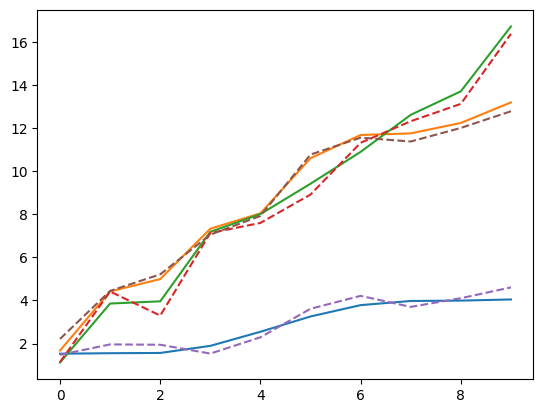

In [130]:
plt.plot(f_example)
plt.plot(f_est.T, "--")
plt.show()